## How to do it...

1. Import required libraries

In [2]:
import tensorflow as tf
import numpy as np
from tf_agents.environments import py_environment, tf_environment, tf_py_environment, utils, wrappers, suite_gym
from tf_agents.specs import array_spec
from tf_agents.trajectories import trajectory, time_step as ts

from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network
from tf_agents.drivers import dynamic_step_driver
from tf_agents.metrics import tf_metrics, py_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
from tf_agents.drivers import py_driver, dynamic_episode_driver
from tf_agents.utils import common

import matplotlib.pyplot as plt

2. Setup the environment for the agent to act within, and define helper functions

In [20]:
class GridWorldEnv(py_environment.PyEnvironment):
    
    def __init__(self):
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=3, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(4,), dtype=np.int32, minimum=[0,0,0,0], maximum=[5,5,5,5], name='observation')
        self._state=[0,0,5,5] # Represents the (row, col, frow, fcol) of the player and finish
        self._episode_ended = False
    
    def action_spec(self):
        return self._action_spec
    
    def observation_spec(self):
        return self._observation_spec
    
    # Reset the state once finished
    def _reset(self):
        self._state=[0,0,5,5]
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.int32))
    
    # Step function handles the state transition by applying an action to the current state to obtain a new one
    def _step(self, action):
        
        if self._episode_ended:
            return self.reset()
        
        self.move(action)
        
        if self.game_over():
            self._episode_ended = True
            
        if self._episode_ended:
            if self.game_over():
                reward = 100
            else:
                reward = 0
            return ts.termination(np.array(self._state, dtype=np.int32), reward)
        else:
            return ts.transition(
                np.array(self._state, dtype=np.int32), reward=0, discount=0.9)
        
    def move(self, action):
        row, col, frow, fcol = self._state[0], self._state[1], self._state[2], self._state[3]
        if action == 0: # down
            if row - 1 > 0:
                self._state[0] -= 1
        if action == 1: # up
            if row + 1 < 6:
                self._state[0] += 1
        if action == 2: # left
            if col - 1 > 0:
                self._state[1] -= 1
        if action == 3: # right
            if col + 1 < 6:
                self._state[1] += 1
                
    def game_over(self):
        row, col, frow, fcol = self._state[0], self._state[1], self._state[2], self._state[3]
        return row==frow and col==fcol
    
def compute_avg_return(environment, policy, num_episodes=10):
    
    total_return = 0.0
    for _ in range(num_episodes):
        
        time_step = environment.reset()
        episode_return = 0.0
        
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            total_return += episode_return
            
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_Step, next_time_step)
    
    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

3. Setup preliminary conditions

In [21]:
# parameter settings

num_iterations = 10_000
initial_collection_steps = 1_000
collect_steps_per_iteration = 1
replay_buffer_capacity = 100_000
fc_layer_params = (100,)
batch_size = 128
learning_rate = 1e-5
log_interval = 200
num_eval_episodes = 2
eval_interval = 1_000

4. Start by creating the enviroments and wrapping them to ensure termination after 100 steps:

In [22]:
train_py_env = wrappers.TimeLimit(GridWorldEnv(), duration=100)
eval_py_env = wrappers.TimeLimit(GridWorldEnv(), duration=100)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

5. We use a Deep Q-Network (DQN) agent for this recipe. As such, we will have to define the network and associated optimizer first:

In [23]:
q_net = q_network.QNetwork(train_env.observation_spec(),
                           train_env.action_spec(),
                           fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

6. Backward compatibility is required here

In [24]:
train_step_counter = tf.compat.v2.Variable(0)

7. Define the agent

In [25]:
tf_agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn = common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

tf_agent.initialize()

eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

8. Create replay buffer and replay observer

In [26]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(data_spec=tf_agent.collect_data_spec,
                                                               batch_size = train_env.batch_size,
                                                               max_length = replay_buffer_capacity)

print(f'Batch Size: {train_env.batch_size}')

replay_observer = [replay_buffer.add_batch]

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric()
]

Batch Size: 1


9. Create a dataset from buffer so that it can be iterated over

In [27]:
dataset = replay_buffer.as_dataset(num_parallel_calls=3,
                                   sample_batch_size=batch_size,
                                   num_steps=2).prefetch(3)

10. Create a driver that will simulate the agent in the game and store the (state, action, reward) tuples in the replay buffer

In [28]:
driver = dynamic_step_driver.DynamicStepDriver(train_env,
                                               collect_policy,
                                               observers=replay_observer + train_metrics,
                                               num_steps=1)

iterator = iter(dataset)

print(compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes))

tf_agent.train = common.function(tf_agent.train)
tf_agent.train_step_counter.assign(0)

final_time_step, policy_state = driver.run()

0.0


11. Run the driver

In [29]:
episode_len = []
step_len = []
for i in range(num_iterations):
    final_time_step, _ = driver.run(final_time_step, policy_state)
    
    experience, _ = next(iterator)
    train_loss = tf_agent.train(experience=experience)
    step = tf_agent.train_step_counter.numpy()
    
    if step % log_interval == 0:
        print(f'step = {step}: loss = {train_loss.loss}')
        episode_len.append(train_metrics[3].result().numpy())
        step_len.append(step)
        print(f'Average episode length: {train_metrics[3].result().numpy()}')
        
    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
        print(f'step = {step}: Average return = {avg_return}')

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 0.027144549414515495
Average episode length: 100.0
step = 400: loss = 0.019206177443265915
Average episode length: 100.0
step = 600: loss = 0.029454940930008888
Average episode length: 74.0
step = 800: loss = 75.94647979736328
Average episode length: 22.5
step = 1000: loss = 152.3343048095703
Average episode length: 36.099998474121094
step = 1000: Average return = 0.0
step = 1200: loss = 224.23692321777344
Average episode length: 50.70000076293945
step = 1400: loss = 149.57388305664062
Average episode length: 60.099998474121094
step = 1600: loss = 74.2284927368164
Average episode length: 53.20000076293945
step = 1800: loss = 292.94647216796875
Average episode length: 42.599998474121094
step = 2000: loss = 0.07912465929985046
Average epis

12. Visualize the training

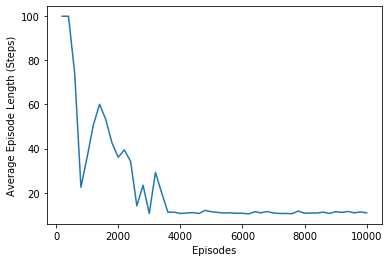

In [30]:
plt.plot(step_len, episode_len)
plt.xlabel('Episodes')
plt.ylabel('Average Episode Length (Steps)')
plt.show()

We can clearly see how the agent learns an ideal policy to be able to navigate to the desired state in the least number of episodes.